# Augmentation Pipeline Tutorial
We describe our algorithm to synthesize image-label pairs that are used to train a 3D StarDist deep network for performing zero-shot inferences on real world light-sheet microscopy data. 

Our image synthesis method builds upon [AnyStar](https://arxiv.org/pdf/2307.07044) to generate more realistic backgrounds by leveraging steerable filters to directionally spread and sharpen noise. For each image we generate background and foreground separately and alpha-blend them to produce a final composite image, which is subject to the same intensity and artifact augmentation routine as AnyStar. 

In this notebook, we provide a step-by-step example to generate a synthetic image-label pair that is used by downstream models for training.

## Label synthesis
We generate $n$ spheres of radii $r$, which are sampled from a uniform distribution $U \sim [4, 20]$. The centers of these spheres are initially placed at the vertices of a regularly-spaced 3D grid, which are then randomly translated. 

In [1]:
import numpy as np
from tqdm import tqdm
from typing import Optional
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

from perlin_numpy import generate_perlin_noise_3d

In [2]:
# set seed for reproducibility
np.random.seed(6969)

In [3]:
def calculate_distance(center_coords, grid_size: Optional[int] = 128):
    # assign n_vox x n_spheres array:
    distances = np.zeros((grid_size**3, len(center_coords)))

    # list all voxel indices
    x = np.arange(grid_size)
    y = np.arange(grid_size)
    z = np.arange(grid_size)
    xx, yy, zz = np.meshgrid(x, y, z, indexing="ij")
    vox_coord = np.stack([xx.ravel(), yy.ravel(), zz.ravel()], axis=1)

    # computes distances using broadcasting
    distances = np.sqrt(
        np.sum((vox_coord[:, np.newaxis, :] - center_coords) ** 2, axis=2)
    )

    return distances

In [4]:
# label generation parameters
grid_size = 128  # side-length in voxels of the synthesized volume
r_mean = 12 # average radius in voxels of initial spheres (equivalent to U ~ [4, 20] -> if r_min = 4; r_max = 20)
# below parameters can be set if r_mean = None
r_min = None 
r_max = None
n_images = 1 # we demonstrate synthesis for a single image

First, we generate center coordinates of all spheres in a grid of shape ```(grid_size, grid_size, grid_size)```

In [5]:
# generate sphere center coordinates
Nz, Ny, Nx = (grid_size, ) * 3
xx = np.arange(0, grid_size, 2 * r_mean)[1:-1]
z, y, x = np.meshgrid(xx, xx, xx, indexing="ij")

Next, the centers of the spheres are randomly translated and dropped from the previously generated grid, to introduce an element of stochasticity.

In [6]:
# random translation of sphere centers
points = np.stack([z.flatten(), y.flatten(), x.flatten()]).T
points = (points).astype(np.float32)
points_perturbed = points + 0.5 * r_mean * np.random.uniform(-1, 1, points.shape)

# randomly drop spheres
ind = np.arange(len(points_perturbed))
np.random.shuffle(ind)

ind_keep = ind[: np.random.randint(2 * len(ind) // 3, len(ind))]  # indices to keep
points_perturbed_kept = points_perturbed[ind_keep]

In [7]:
# randomly scale sphere radii to a uniform distribution
rads = r_mean * np.random.uniform(0.6, 1.2, len(points))
rads_kept = rads[ind_keep]  # randomly drop the same radii

# compute spheres distance matrix
dist_mtx = calculate_distance(points_perturbed_kept)

Since cellular bodies are typically non-spherical, the distances $d_{ij}$ between each voxel $j$ and sphere $i$ is corrupted by additive Perlin noise. The resultant image grid is now (randomly) zero or reflection padded for simulating varied nuclei distribution.

In [8]:
# sample perlin noise
noise_sample = generate_perlin_noise_3d((Nz, Ny, Nx), res=(8, 8, 8))

# corrupt distance matrix using perlin noise
corr_dist_mtx = dist_mtx + 0.9 * r_mean * noise_sample.flatten()[:, np.newaxis]

Now, we assign labels to all pixels!

In [9]:
labelmap = np.zeros(grid_size**3, dtype=np.uint16)
for j in tqdm(range(dist_mtx.shape[0]), desc=f"assigning labels..."):
    finder = np.where(corr_dist_mtx[j, :] < rads_kept)[0]
    if len(finder) > 0:
        # assign to closes label in case of ambiguity
        value = finder[np.argmin(corr_dist_mtx[j, finder])]
        labelmap[j] = value + 1

# reshape to (grid_size, grid_size, grid_size)
labelmap = np.reshape(labelmap, (grid_size, grid_size, grid_size))

assigning labels...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2097152/2097152 [00:04<00:00, 447242.27it/s]


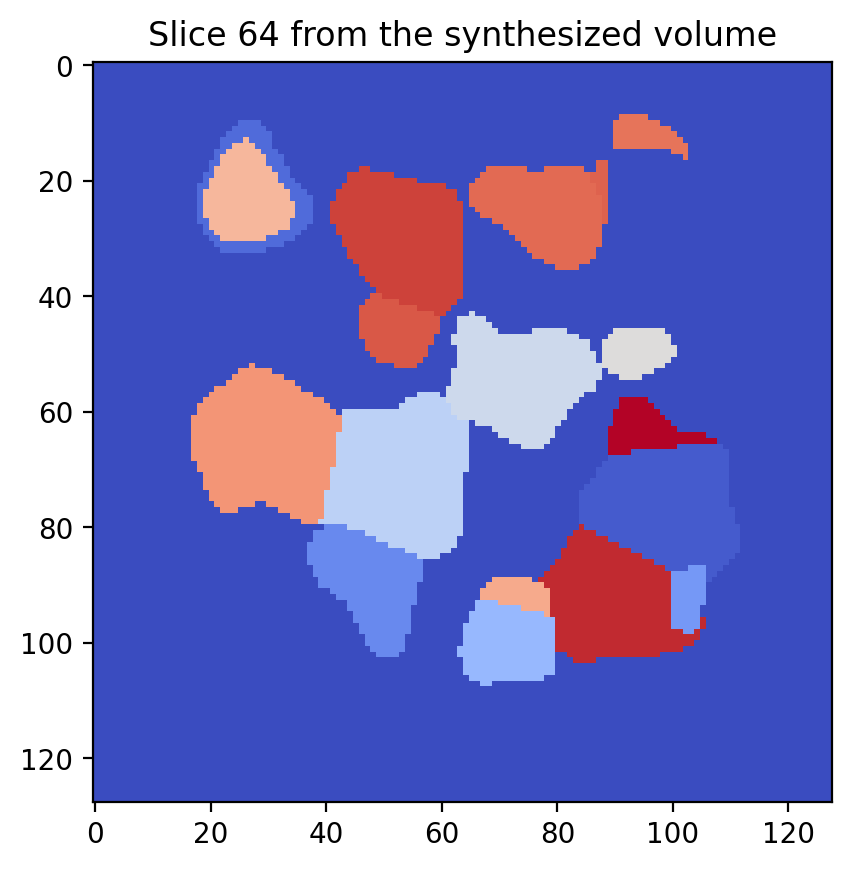

In [10]:
sl_num = 64 # visualize a slice from the 3d image volume
plt.figure()
plt.imshow(labelmap[sl_num,...], cmap='coolwarm')
plt.title(f'Slice {sl_num} from the synthesized volume')
plt.show()

# Image Synthesis

For a label map $L$ having $n$ instances, an initial image is synthesized by sampling foreground intensities from a conditional, $n$-component GMM, where each of its parameters $\{\mu_i, \sigma_i\}$ are sampled from a uniform distribution for every image. We simulate variable backgrounds to emulate characteristic staining patterns observed in light-sheet microscopy. To synthesize bright foreground instances, we repeat the process described previously, of sampling instances from a $n$-component GMM.

However, to simulate accurate geometric and topological features in the background, we rely on a generative model as described in [SynthMorph](https://github.com/voxelmorph/voxelmorph) and [Neurite](https://github.com/adalca/neurite). Next, we synthesize a directionally sharpened background using a steered filter having a spherical harmonic basis. The composite image is formed by alpha blending the foreground and background images, with the value of α chosen empirically.

First, we define some helper functions for spherical harmonics: 
1. Compute harmonics of degree $\ell$, order $m$ at ($\theta$, $\phi$)
2. Convert spherical to cartesian coordinates
3. Sampling function for a random 3D Gaussian Kernel
4. Rotation of 3D kernels
5. Project a Gaussian kernel to a spherical harmonic basis

In [11]:
import tensorflow as tf

from scipy.special import sph_harm
from skimage.transform import resize
from scipy.ndimage import rotate, convolve
from skimage.measure import label as unique_label

2024-07-22 07:50:25.788276: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-22 07:50:25.822062: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-22 07:50:25.822087: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-22 07:50:25.822108: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-22 07:50:25.828230: I tensorflow/core/platform/cpu_feature_g

In [12]:
def compute_spherical_harmonics(l, m, phi, theta):
    # compute harmonics of degree l, order m at (theta, phi)
    return sph_harm(m, l, phi, theta)

def spherical_to_cartesian(r, theta, phi):
    # convert spherical to cartesian coordinates
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)

    return x, y, z

def gaussian_3d_kernel(size, sigma):
    # sample a random 3d gaussian kernel
    x = np.random.normal(0, 1, size[0])
    y = np.random.normal(0, 1, size[1])
    z = np.random.normal(0, 1, size[2])

    x, y, z = np.meshgrid(x, y, z, indexing="ij")

    distance = np.sqrt(x**2 + y**2 + z**2)
    kernel = np.exp(-(distance**2 / (2.0 * sigma**2)))
    kernel = kernel / np.sum(kernel)
    return kernel, (x, y, z)

def rotate_3d_kernel(kernel, angles):
    rotated_kernel = rotate(kernel, angle=angles[0], axes=(1, 2), reshape=False)
    rotated_kernel = rotate(rotated_kernel, angle=angles[1], axes=(0, 2), reshape=False)
    rotated_kernel = rotate(rotated_kernel, angle=angles[2], axes=(0, 1), reshape=False)
    return rotated_kernel

def project_spherical_harmonic(size, sigma, l, m, angles):
    # compute a (random) 3d gaussian kernel
    gaussian, (x, y, z) = gaussian_3d_kernel(size=size, sigma=sigma)

    # steer the gaussian
    gaussian = rotate_3d_kernel(kernel=gaussian, angles=angles)

    # cartesian to spherical coordinates
    r = np.sqrt(x**2 + y**2 + z**2)
    # ensure range of arccos is [-1, 1]
    theta = np.arccos(np.clip(z / r, -1, 1))
    phi = np.sign(y) * np.arccos(np.clip(x / np.sqrt(x**2 + y**2), -1, 1))

    harmonic_basis = compute_spherical_harmonics(l=l, m=m, phi=phi, theta=theta).real

    projected_gaussian = (
        harmonic_basis * gaussian
    )  # project gaussians to a spherical harmonic basis

    return projected_gaussian

For each label map, we generate an initial image synthesized using either by sampling from a conditional GMM or 3D Perlin noise. Before we do so, we pad and resize images in order to simulate varying object densities. The padding mode is chose randomly. Here, we demonstrate one such mode.

In [13]:
# mode with which to pad initial label maps
randmode = np.random.choice(["constant", "reflect"])

# amount to pad initial label maps along each axis
randpad_x = np.random.choice([0, 32, 64, 96])
randpad_y = np.random.choice([0, 32, 64, 96])
randpad_z = np.random.choice([0, 32, 64, 96])

print(f'Padding mode: {randmode}\nx padding: {randpad_x}\ny padding: {randpad_y}\nz padding: {randpad_z}')

Padding mode: reflect
x padding: 0
y padding: 64
z padding: 32


In [14]:
# pad label pairs
label_copy = labelmap.copy() # avoid overwriting in memory (just for this tutorial)
current_labels = np.pad(
    label_copy, 
    [
        [randpad_x, randpad_x],
        [randpad_y, randpad_y],
        [randpad_z, randpad_z]
    ],
    mode=randmode
)

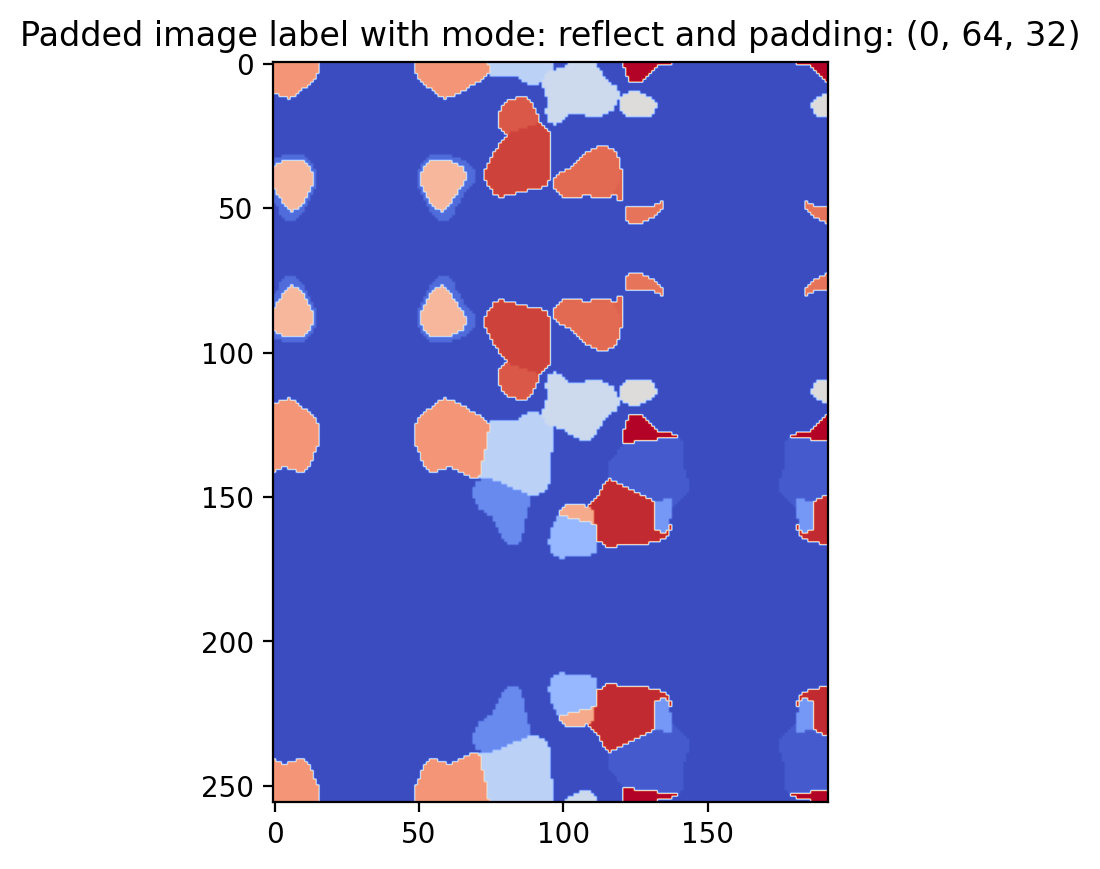

In [15]:
# visualize intermediate result
sl_num = 64
plt.figure()
plt.title(f'Padded image label with mode: {randmode} and padding: ({randpad_x}, {randpad_y}, {randpad_z})')
plt.imshow(current_labels[sl_num,...], cmap='coolwarm')
plt.show()

Note that we would need to resize the above padded labels such that the size of all volumes remains consistent (here, $(128\times 128\times 128)$). Of course, we would also like to make sure that all individual labels are remapped to ensure uniquness.

In [16]:
# resize padded labels 
current_labels = resize(
    current_labels, 
    (128, 128, 128),
    preserve_range=True,
    anti_aliasing=False,
    order=0,
)

# make sure each label is unique:
current_labels = unique_label(current_labels).astype(np.uint16)

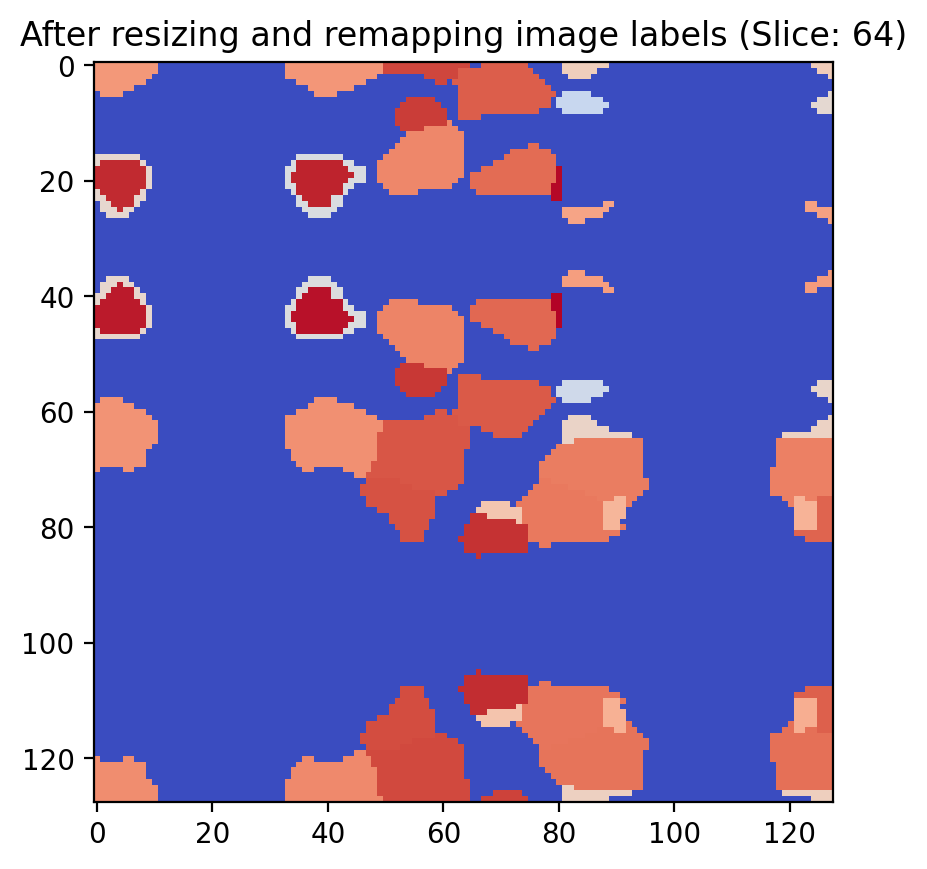

In [17]:
# plot intermediate result
sl_num = 64
plt.figure()
plt.title(f'After resizing and remapping image labels (Slice: {sl_num})')
plt.imshow(current_labels[sl_num,...], cmap='coolwarm')
plt.show()

Now that we have an image label, we want to synthesize a background. As previously described, this is done by sampling intensities from a conditional GMM distribution where the $\{\mu, \sigma\}$ pairs are sampled (from a uniform distribution) uniquely for every unique label.

In [18]:
import cv2 as cv
import neurite as ne
import voxelmorph as vxm

from lsm.synthetic.synthseg_utils import (
    draw_value_from_distribution,
    SampleConditionalGMM,
)

In [19]:
# sample mean and standard deviations
means = draw_value_from_distribution(
    hyperparameter=None, 
    size=len(np.unique(current_labels)),
    distribution='uniform',
    centre=125,
    default_range=100, 
    positive_only=True
)

stds = draw_value_from_distribution(
    hyperparameter=None,
    size=len(np.unique(current_labels)),
    distribution='uniform',
    centre=15,
    default_range=10, 
    positive_only=True
)

To synthesize background noise, we choose randomly from one of 3 options - plain, random or perlin noise. 

In [20]:
backgnd_mode = np.random.choice(["plain", "rand", "perlin"])
print(f'Background noise: {backgnd_mode}')

# plain or random noise is the same structure
if backgnd_mode == 'plain' or backgnd_mode == 'rand':
    min_mean = means.min() * np.random.rand(1)
    means[0] = 1. * min_mean
    stds[0] = np.random.uniform(0., 5., 1)

# sample perlin noise at different octave scales
elif backgnd_mode == 'perlin':
    n_texture_labels = np.random.randint(1, 21)
    idx_texture_labels = np.arange(0, n_texture_labels, 1)
    im = ne.utils.augment.draw_perlin(
        out_shape=(128, 128, 128, n_texture_labels),
        scales=(32, 64),
        max_std=1,
    )
    try:
        warp = ne.utils.augment.draw_perlin(
            out_shape=(128, 128, 128, n_texture_labels, 3),
            scales=(16, 32, 64),
            max_std=16,
        )
    except: 
        pass

    # transform and create background label map.
    im = vxm.utils.transform(im, warp)
    background_struct = np.uint8(tf.argmax(im, axis=-1))

    # background moments for GMM:
    background_means = draw_value_from_distribution(
        hyperparameter=None,
        size=len(np.unique(idx_texture_labels)),
        distribution="uniform",
        centre=125,
        default_range=100,
        positive_only=True,
    )
    background_stds = draw_value_from_distribution(
        hyperparameter=None,
        size=len(np.unique(idx_texture_labels)),
        distribution="uniform",
        centre=15,
        default_range=10,
        positive_only=True,
    )

Background noise: perlin


2024-07-22 07:50:52.030197: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


To be able to generate realistic cell texture, we sample noise from a Perlin distribution (ie: foreground). This is consequently used to create a new synthetic layer. 

In [21]:
# perlin noise is sampled at varying scales 
randperl = ne.utils.augment.draw_perlin(
    out_shape=(128, 128, 128, 1),
    scales=(2, 4, 8, 16, 32),
    max_std=5.0,
)[..., 0].numpy()

# normalize noise to the range [0, 1]
randperl = (randperl - randperl.min()) / (randperl.max() - randperl.min())

We now create a foreground image by sampling from a conditional GMM (again!). This is built on top of the [SynthMorph](https://github.com/voxelmorph/voxelmorph) code, as mentioned earlier.

In [22]:
synthlayer = SampleConditionalGMM(np.unique(current_labels))
synthimage = synthlayer(
    [
        tf.convert_to_tensor(
            current_labels[np.newaxis, ..., np.newaxis],
            dtype=tf.float32,
        ),
        tf.convert_to_tensor(
            means[tf.newaxis, ..., tf.newaxis],
            dtype=tf.float32,
        ),
        tf.convert_to_tensor(
            stds[tf.newaxis, ..., tf.newaxis],
            dtype=tf.float32,
        ),
    ]
)[0, ..., 0].numpy()

All foreground (ie: non-zero) pixels are corrupted using Perlin noise to simulate varying cell textures. 

In [23]:
synthimage[current_labels > 0] = (
    synthimage[current_labels > 0] * randperl[current_labels > 0]
)
del synthlayer # delete synthlayer object to make the code faster (reduce reference count)

Next, we synthesize the background image separately. Here, we *directionally* steer noise (either Perlin or random / uniform) using a kernel whose parameters are sampled from a random normal distribution. 

After synthesizing the background, the foreground + background images are composited using alpha blending. In contrast to ```AnyStar```, instead of replacing non-foreground pixels, we alpha blend the background with the foreground to better capture artifacts of fluorescence microscopy. 

In [24]:
if backgnd_mode == "plain" or backgnd_mode == "rand":
    # convolve random noise with a 3d steerable spherical basis kernel
    # sampled from a normal distribution
    theta = np.random.uniform(0, 360)
    psi = np.random.uniform(0, 360)
    phi = np.random.uniform(-90, 90)
    spherical_basis_kernel = project_spherical_harmonic(
        size=(7, 7, 7),
        sigma=1.0,
        l=2,
        m=2,
        angles=(theta, psi, phi),
    )
    x = np.random.randn(128, 128, 128)
    steerable_random_conv = convolve(x, spherical_basis_kernel)
    # alpha blend noise with foreground
    alpha = 3e-3
    synthimage = cv.addWeighted(
        synthimage,
        alpha,
        steerable_random_conv.astype("float32"),
        1 - alpha,
        0,
    )

elif backgnd_mode == "perlin":
    synthlayer = SampleConditionalGMM(idx_texture_labels)
    synthbackground = synthlayer(
        [
            tf.convert_to_tensor(
                background_struct[np.newaxis, ..., np.newaxis],
                dtype=tf.float32,
            ),
            tf.convert_to_tensor(
                background_means[tf.newaxis, ..., tf.newaxis],
                dtype=tf.float32,
            ),
            tf.convert_to_tensor(
                background_stds[tf.newaxis, ..., tf.newaxis],
                dtype=tf.float32,
            ),
        ]
    )[0, ..., 0].numpy()
    perlin_kernel = gaussian_3d_kernel(size=(7, 7, 7), sigma=1.0)
    # note that all angles are in degrees
    theta = np.random.uniform(0, 360)
    psi = np.random.uniform(0, 360)
    phi = np.random.uniform(-90, 90)
    spherical_basis_kernel = project_spherical_harmonic(
        size=(7, 7, 7),
        sigma=1.0,
        l=2,
        m=2,
        angles=(theta, psi, phi),
    )
    x = np.random.randn(128, 128, 128)
    steerable_random_conv = convolve(x, spherical_basis_kernel).astype(
        synthimage.dtype
    )  # typecast for alpha-blending
    alpha = 0.4
    # alpha blend perlin noise with foreground
    synthimage = cv.addWeighted(
        synthimage, alpha, steerable_random_conv, 1 - alpha, 0
    )
    del synthlayer

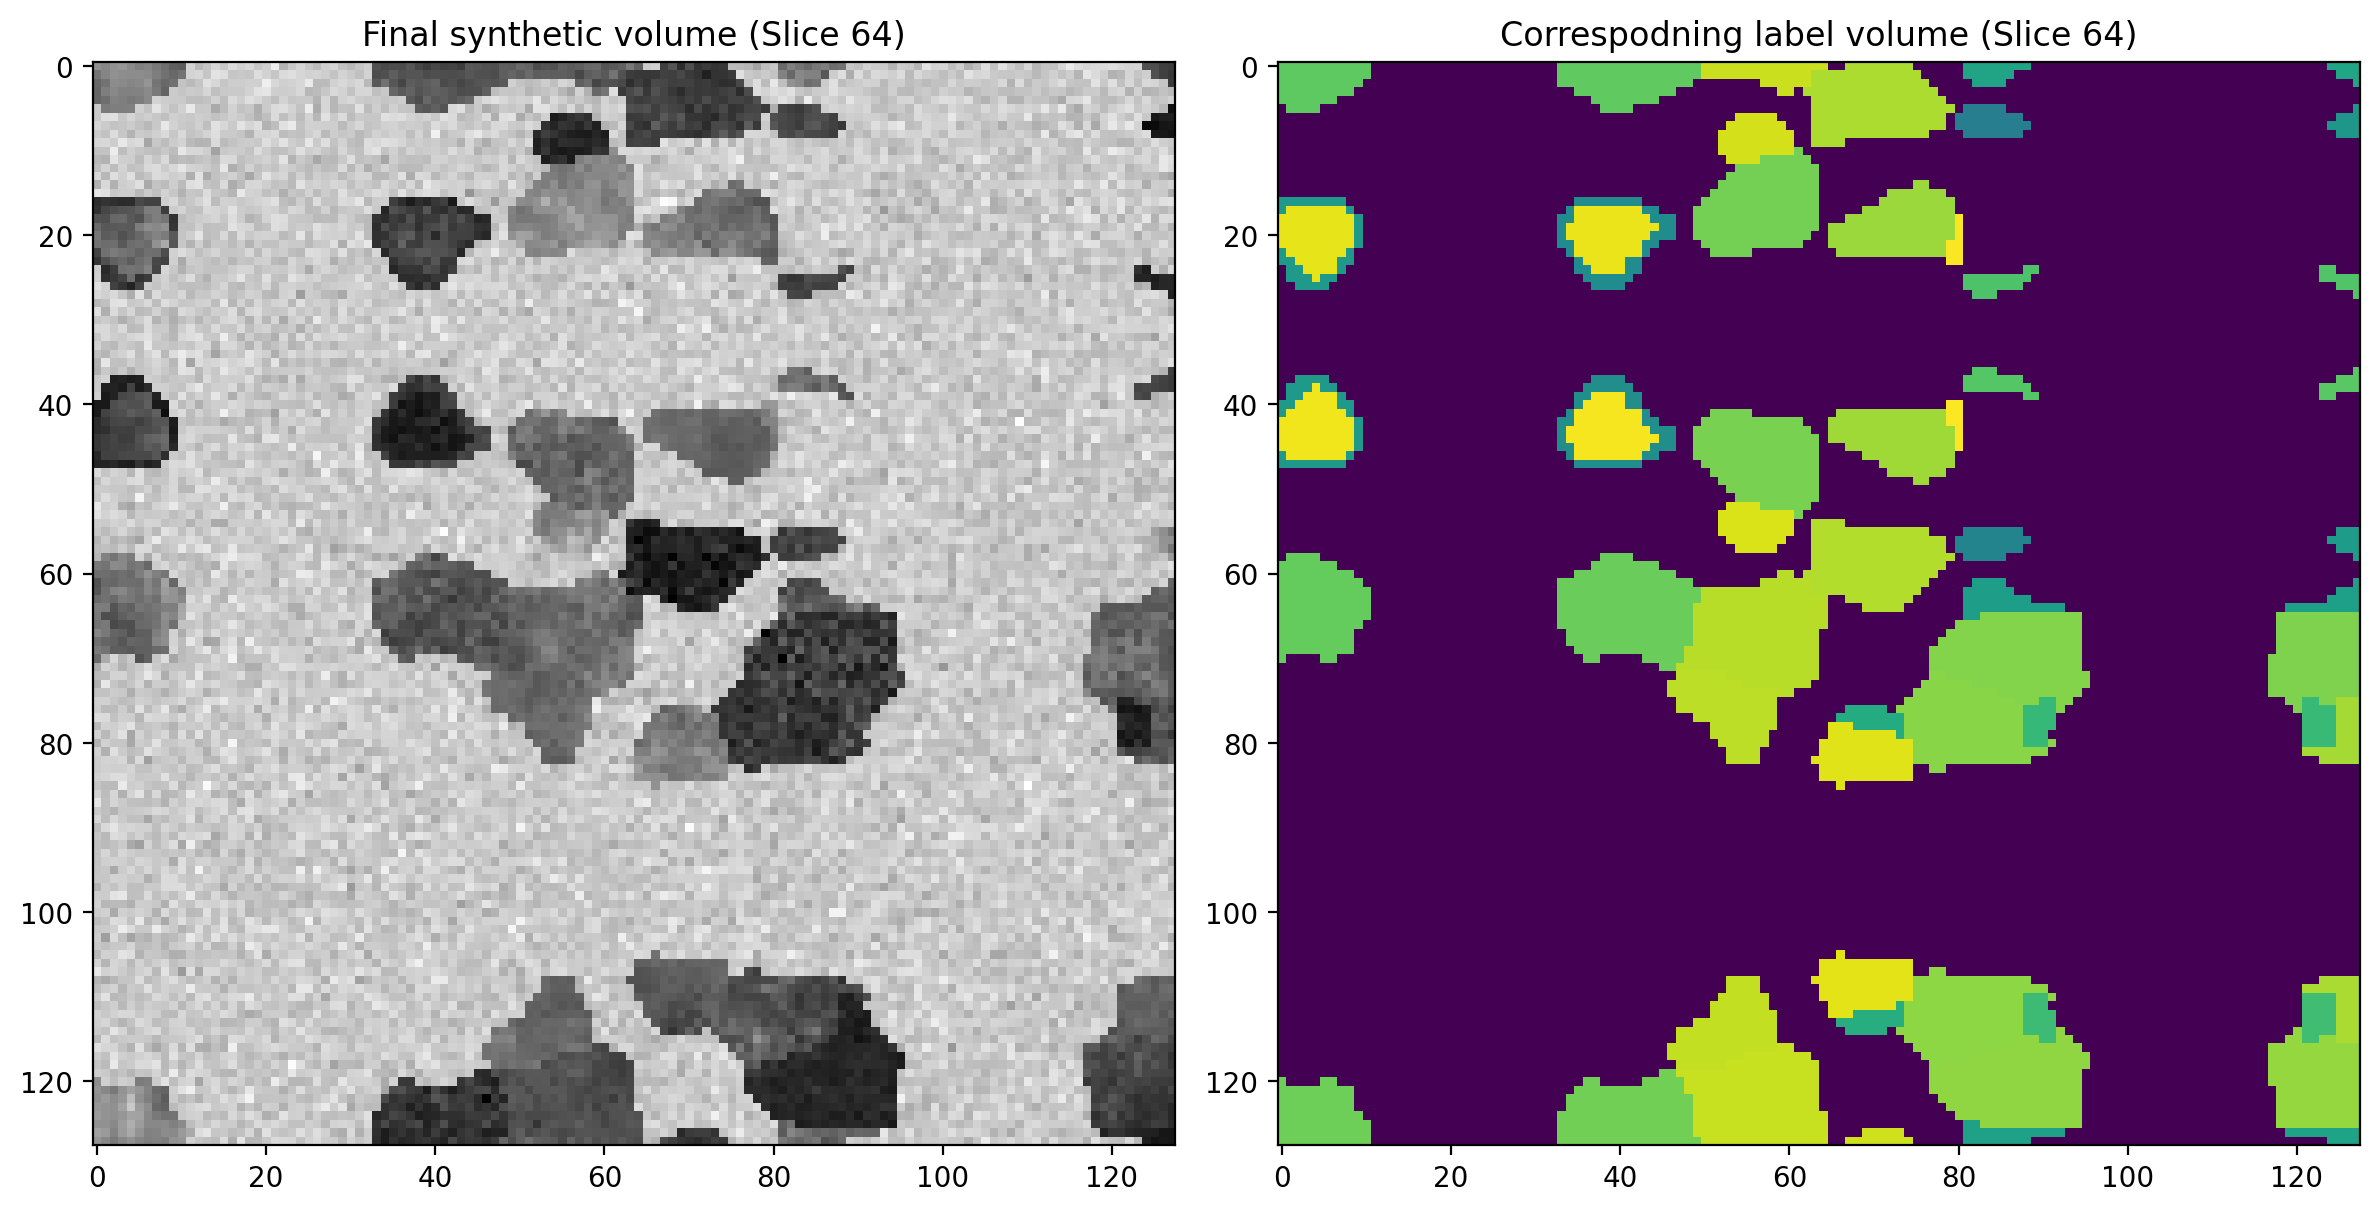

In [25]:
sl_num = 64
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(synthimage[sl_num,...], cmap='gray')
plt.title(f'Final synthetic volume (Slice {sl_num})')

plt.subplot(122)
plt.imshow(current_labels[sl_num,...], cmap='viridis')
plt.title(f'Correspodning label volume (Slice {sl_num})')
plt.tight_layout()
plt.show()

# Augmentation Pipeline
We domain randomize the synthetic images for 2 primary reasons:
1. Augmentations domain randomize our dataset. This enforces our trained neural network to focus on *regions of interest*, hence making it robust to biological and imaging artifacts.
2. Increasing size of the dataset for training our neural network.

Importantly, we perform **offline** augmentations, ie: we save all augmented images on disk. This routine is identical to that of ```AnyStar```.

In [26]:
import monai
from monai.data import list_data_collate
from monai.transforms import (
    RandRotate90d,
    ScaleIntensityd,
    Compose,
    LoadImaged,
    RandAxisFlipd,
    RandGaussianNoised,
    RandBiasFieldd,
    RandAdjustContrastd,
    RandGaussianSmoothd,
    RandGaussianSharpend,
    RandHistogramShiftd,
    RandSpatialCropd,
    Rand3DElasticd,
    EnsureTyped,
    RandGibbsNoised,
    EnsureChannelFirstd,
    RandKSpaceSpikeNoised,
    RandRicianNoised,
    RandCoarseDropoutd,
    RandZoomd,
    RandAffined,
)

import torch
from torch.utils.data import DataLoader
from skimage.util import random_noise
from skimage.measure import label as unique_label

from lsm.synthetic.augmentation_pipeline import worker_init_fn

In [27]:
# compose training transforms
def get_transforms():
    """
    MONAI Composed transforms used for the A(.) function from the paper.
    """
    train_transforms = Compose(
        [
            LoadImaged(keys=["image", "label"]),
            EnsureChannelFirstd(keys=["image", "label"]),
            EnsureTyped(keys=["image", "label"]),
            ScaleIntensityd(keys="image"),
            RandSpatialCropd(
                keys=["image", "label"],
                roi_size=[64, 64, 64],
            ),
            RandZoomd(
                prob=1.0,
                keys=["image", "label"],
                min_zoom=0.4,
                max_zoom=1.4,
                mode=["trilinear", "nearest"],
                padding_mode="reflect",
            ),
            RandAffined(
                mode=("bilinear", "nearest"),
                keys=["image", "label"],
                rotate_range=(np.pi / 4, np.pi / 4, np.pi / 4),
                translate_range=(16, 16, 16),
                prob=1.0,
                padding_mode="reflection",
            ),
            RandBiasFieldd(keys=["image"], prob=1.0, coeff_range=(0.0, 0.1)),
            RandGaussianNoised(keys=["image"], prob=0.25),
            RandKSpaceSpikeNoised(keys=["image"], prob=0.2),
            RandAdjustContrastd(keys=["image"], prob=0.8),
            RandGaussianSmoothd(
                keys=["image"],
                prob=0.8,
                sigma_x=(0.0, 0.333),
                sigma_y=(0.0, 0.333),
                sigma_z=(0.0, 0.333),
            ),
            RandRicianNoised(keys=["image"], prob=0.2, std=0.05),
            RandGibbsNoised(keys=["image"], prob=0.5, alpha=(0.0, 0.5)),
            RandGaussianSharpend(keys=["image"], prob=0.25),
            RandHistogramShiftd(keys=["image"], prob=0.1),
            RandAxisFlipd(keys=["image", "label"], prob=1.0),
            RandRotate90d(keys=["image", "label"], prob=1.0),
            Rand3DElasticd(
                keys=["image", "label"],
                sigma_range=(2, 5),
                magnitude_range=(8, 20),
                mode=("bilinear", "nearest"),
                scale_range=(0.3, 0.3, 0.3),
                spatial_size=(64, 64, 64),
                shear_range=(0.5, 0.5, 0.5),
                prob=1.0,
                padding_mode="zeros",
            ),
            ScaleIntensityd(keys="image"),
            RandCoarseDropoutd(
                prob=0.2,
                keys=["image", "label"],
                fill_value=0,
                holes=20,
                spatial_size=12,
            ),
        ]
    )
    return train_transforms

In [28]:
train_transforms = get_transforms()

In [29]:
# save images on disk for monai cache dataloader object
import os
import nibabel as nib

synthimage_nifti = nib.Nifti1Image(synthimage, affine=np.eye(4))
labels_nifti = nib.Nifti1Image(current_labels, affine=np.eye(4))

nib.save(synthimage_nifti, 'synth.nii.gz')
nib.save(labels_nifti, 'labels.nii.gz')

In [30]:
# dict of data to pass into dataloader
train_files = [{"image": os.path.join('./', 'synth.nii.gz'), 
                "label": os.path.join('./', 'labels.nii.gz')}]

In [31]:
train_ds = monai.data.CacheDataset(data=train_files, transform=train_transforms)
train_loader = DataLoader(
    train_ds,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    collate_fn=list_data_collate,
    pin_memory=False,
    worker_init_fn=worker_init_fn,
)

Loading dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.37it/s]


  0%|                                                                                                                                                                | 0/1 [00:00<?, ?it/s]

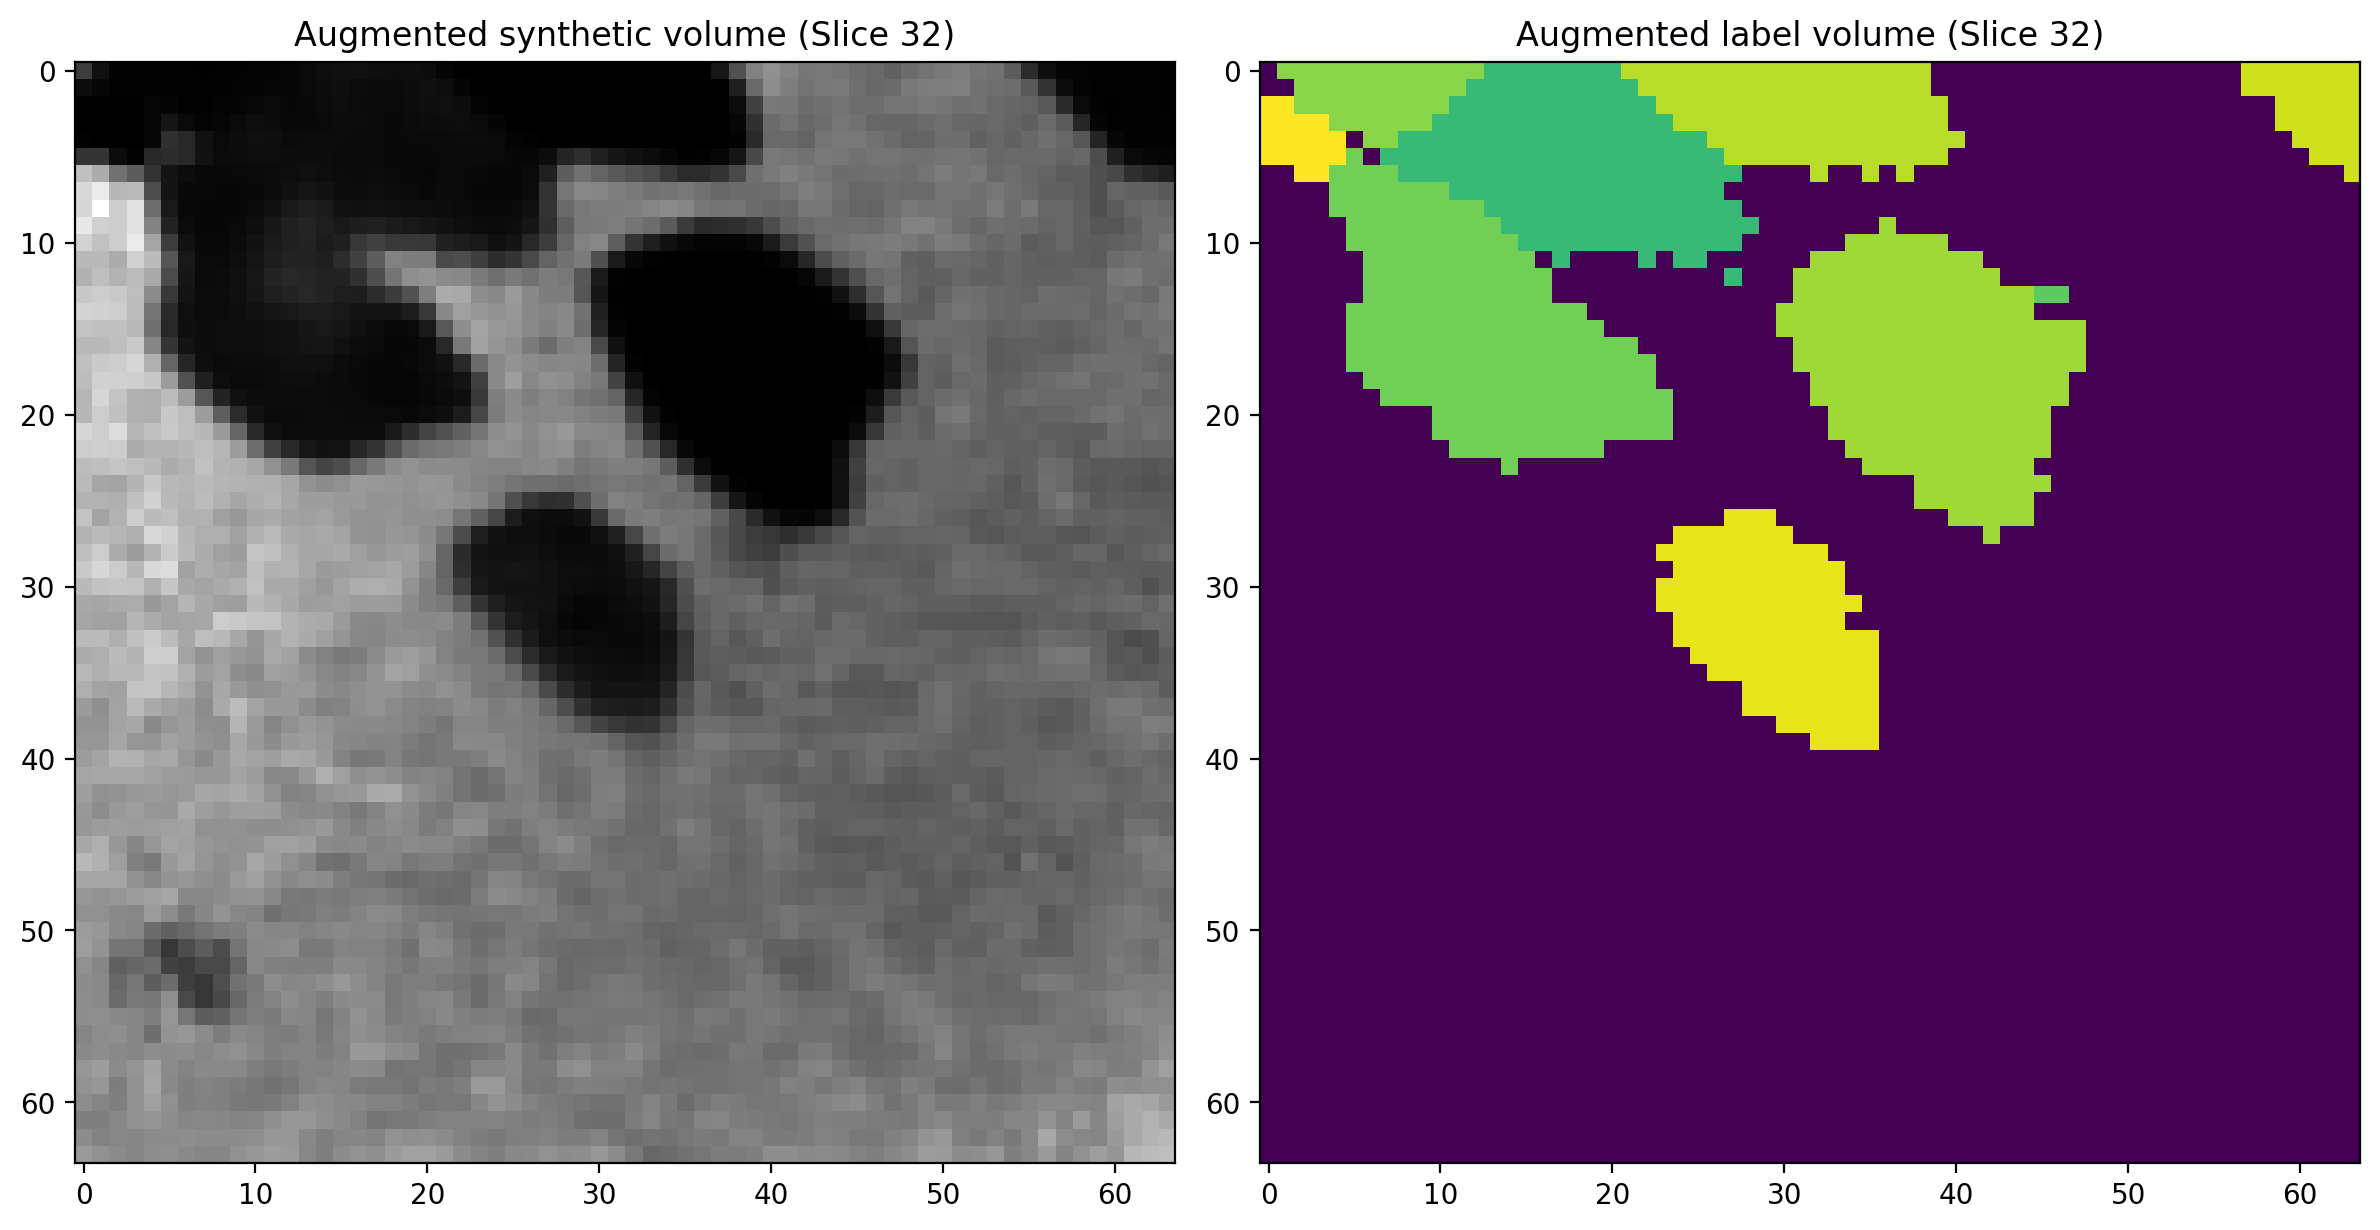

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.12it/s]


In [32]:
# apply augmentations
for batch in tqdm(train_loader):
    inputs, labels = batch["image"], batch["label"]
    if inputs.squeeze().data.sum() == 0:
        continue
    nonzero = (inputs.squeeze().data > 0).astype(np.float32)
    if np.random.uniform(0, 1) < 0.2:
        noise_choice = np.random.choice(["gaussian", "poisson", "speckle"])
        img = random_noise(inputs.squeeze().data, mode=noise_choice)
        img = img * nonzero
    else:
        img = 1.0 * inputs.squeeze().data

    separate_labels = unique_label(labels.squeeze().data).astype(np.uint16)

    sl_num = 32
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.imshow(img[sl_num,...], cmap='gray')
    plt.title(f'Augmented synthetic volume (Slice {sl_num})')
    
    plt.subplot(122)
    plt.imshow(separate_labels[sl_num,...], cmap='viridis')
    plt.title(f'Augmented label volume (Slice {sl_num})')
    plt.tight_layout()
    plt.show()